Note: This is an adaptation of the notebook found in optical_flow repo, commit ....,
which in its original form works with sinabs from commit ... and sinabs-slayer, commit ...

This adaptation should work with sinabs and exodus in their most recent versions (25.02.2022) and is independent of the optical_flow project. 

# Why does sinabs-slayer model not work?

This notebook will show that for the wheel-motion classification toy task, the same model architecture can be trained with sinabs but training on sinabs-slayer fails. We will try to explore why this is the case.

The notebook's code is based on the script `binary_task.py`

SPOILER:
The problem was exploding gradients in the slayer model. Enabling an option to scale down the surrogate gradients resolved it.
The problem can be reproduced by setting `kwargs_spiking["scale_grads"]` to 1 (second code cell), which corresponds to the original value.

In [1]:
### --- Imports

# Set this to inline or notebook if widget is not supported. Animation might not work then.
%matplotlib widget

import torch
from torch import nn
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation

from slayerSNN import loss as SpikeLoss

from sinabs.from_torch import from_model
from sinabs.utils import get_activations
import sinabs.layers as sl

from data import InvertDirDataset
from binary_models import SlayerModel, ExodusModel

(2, 256, 256, 299)


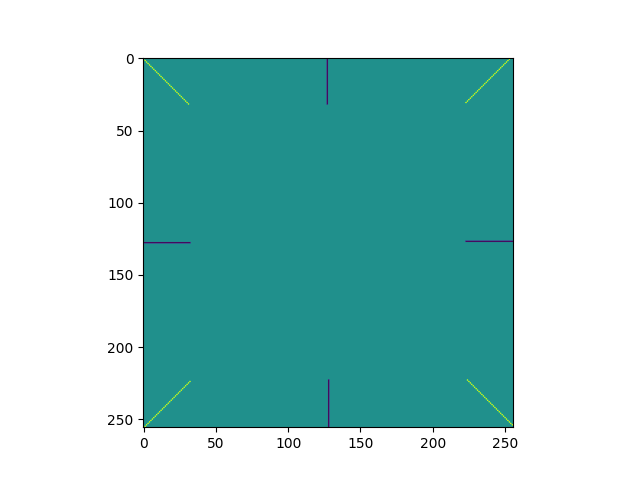

In [2]:
### --- Data loading and inspection
raster = np.load("rotation_events300.npy")
raster = raster.transpose(1,2,3,0)
print(raster.shape)

raster_merged = (raster[1] - raster[0]).transpose(-1,0,1)
fig, ax = plt.subplots()
screen = ax.imshow(raster_merged[0], vmin=np.min(raster_merged), vmax=np.max(raster_merged))

def update_plot(frm):
    return screen.set_data(frm)

anim = FuncAnimation(fig, update_plot, frames=raster_merged)

In [3]:
### --- Settings and hyperparameters
lr = 1e-3
num_epochs = 40
optimizer_class = torch.optim.SGD  # torch.optim.Adam

# - Model parameters
kwargs_model = {
    "grad_width": 0.5,  # 0.5
    "grad_scale": 1,  # 0.02
    "thr": 1,
    "num_ts": raster.shape[-1],
}

In [4]:
# - Datset and loader
downsample = 1
num_ts = raster.shape[-1] // downsample
# Set sample_size and step_size such that each sample corresponds to all frames of one class
ds = InvertDirDataset(
    raster, sample_size=num_ts, step_size=num_ts, downsample=downsample
)
dl = torch.utils.data.DataLoader(ds, batch_size=1, shuffle=True)

# - Loss function
loss_func = torch.nn.CrossEntropyLoss()

# - Sinabs model
model_sinabs = ExodusModel(**kwargs_model).cuda()
model_sinabs.reset()
print("Sinabs model:")
print(model_sinabs)

model_slayer = SlayerModel(**kwargs_model).cuda()
print("Slayer model:")
print(model_slayer)

Sinabs model:
ExodusModel(
  (pool0): AvgPool2d(kernel_size=4, stride=4, padding=0)
  (conv0): Conv2d(2, 4, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), bias=False)
  (spk0): IAFSqueeze-module, backend: exodus
  (pool1): AvgPool2d(kernel_size=4, stride=4, padding=0)
  (conv1): Conv2d(4, 8, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), bias=False)
  (spk1): IAFSqueeze-module, backend: exodus
  (pool2): AvgPool2d(kernel_size=4, stride=4, padding=0)
  (linear): Linear(in_features=128, out_features=2, bias=False)
)
Slayer model:
SlayerModel(
  (slayer): SlayerLayer()
  (pool0): _poolLayer(1, 1, kernel_size=(4, 4, 1), stride=(4, 4, 1), bias=False)
  (conv0): _convLayer(2, 4, kernel_size=(7, 7, 1), stride=(1, 1, 1), padding=(3, 3, 0), bias=False)
  (pool1): _poolLayer(1, 1, kernel_size=(4, 4, 1), stride=(4, 4, 1), bias=False)
  (conv1): _convLayer(4, 8, kernel_size=(7, 7, 1), stride=(1, 1, 1), padding=(3, 3, 0), bias=False)
  (pool2): _poolLayer(1, 1, kernel_size=(4, 4, 1), stride

In [5]:
# - Transfer weights from sinabs to slayer model to ensure same initial conditions
model_slayer.conv0.weight.data = model_sinabs.conv0.weight.data.unsqueeze(-1).clone()
model_slayer.conv1.weight.data = model_sinabs.conv1.weight.data.unsqueeze(-1).clone()
model_slayer.linear.weight.data = model_sinabs.linear.weight.data.clone().reshape(2, 8, 4, 4, 1)

Now the two models should produce the same output for a given input. Let's make sure this is the case

In [6]:
# - Compare outputs before training
outputs_slayer = []
outputs_sinabs = []

with torch.no_grad():
    # Load input from dataset to avoid shuffling.
    for inp, *__ in ds:
        # Add batch dimension
        inp = inp.unsqueeze(0).cuda()
        outputs_slayer.append(model_slayer(inp))
        outputs_sinabs.append(model_sinabs(inp))
        model_sinabs.reset()

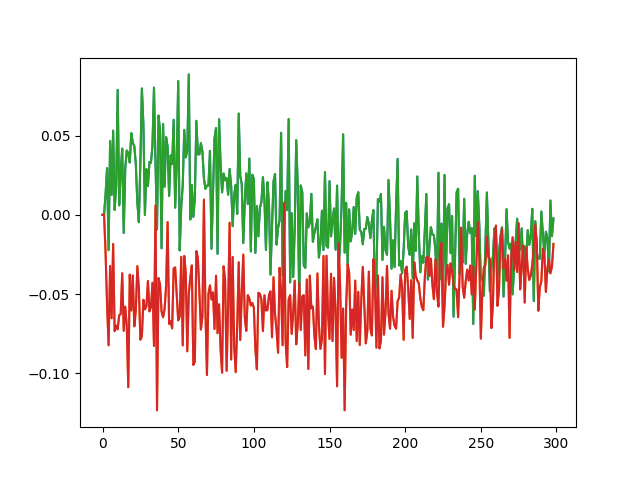

In [7]:
os = outputs_slayer[1].squeeze(0).cpu().detach()
oe = outputs_sinabs[1].squeeze(0).cpu().detach()
plt.figure()
plt.plot(oe.t())
plt.plot(os.t())
plt.show()

Outputs seem very similar.

In [8]:
# - Set up training
loss_func = torch.nn.CrossEntropyLoss()
optim_sin = optimizer_class(model_sinabs.parameters(), lr=lr)
optim_slr = optimizer_class(model_slayer.parameters(), lr=lr)

# - Do a single batch

dl_iter = iter(dl)
inp, tgt, onehot = next(dl_iter)
print("Target:", tgt)
inp = inp.cuda()

# Sinabs
out_sin = model_sinabs(inp).sum(-1).cpu()
optim_sin.zero_grad()
loss_sin = loss_func(out_sin, tgt)
loss_sin.backward()
grads_sin = [p.grad for p in model_sinabs.parameters()]
model_sinabs.reset()

# Slayer
out_slr = model_slayer(inp).sum(-1).cpu()
optim_slr.zero_grad()
loss_slr = loss_func(out_slr, tgt)
loss_slr.backward()
grads_slr = [p.grad.squeeze(-1) for p in model_slayer.parameters() if p.grad is not None]

print(f"Losses - Sinabs: {loss_sin.item()}, Slayer: {loss_slr.item()}")


Target: tensor([1])
Losses - Sinabs: 15.732162475585938, Slayer: 15.733272552490234


In [9]:
print([torch.max(g) for g in grads_sin])
print([torch.max(g) for g in grads_slr])

print([torch.std(g) for g in grads_sin])
print([torch.std(g) for g in grads_slr])

[tensor(15.4781, device='cuda:0'), tensor(45.4239, device='cuda:0'), tensor(48.6875, device='cuda:0')]
[tensor(98430.9766, device='cuda:0'), tensor(4583.5254, device='cuda:0'), tensor(48.6875, device='cuda:0')]
[tensor(5.6277, device='cuda:0'), tensor(7.5076, device='cuda:0'), tensor(14.0233, device='cuda:0')]
[tensor(29269.4648, device='cuda:0'), tensor(732.0382, device='cuda:0'), tensor(14.0233, device='cuda:0')]


It turns out that with the default scaling (`kwargs_spiking["scale_grads"] = 1.0`), the gradients in the slayer model explode. After trying a few values, setting the scale to 0.02 seems to give reasonable gradients.
Let's train both models to see, whether everything works now.

In [10]:
# - Training loop

mistakes_sin = []
mistakes_slr = []

for ep in range(num_epochs):
    print(f"Epoch {ep} ------------------------------------------------------")
    for inp, tgt, __ in dl:
        inp = inp.cuda()       
        
        # Sinabs
        out_sin = model_sinabs(inp).sum(-1).cpu()
        __, predict_sin = torch.max(out_sin, 1)
        optim_sin.zero_grad()
        loss_sin = loss_func(out_sin, tgt)
        loss_sin.backward()
        optim_sin.step()
        model_sinabs.reset()
        sin_right = tgt.item() == predict_sin.item()
        mistakes_sin.append(int(not sin_right))

        # Slayer
        out_slr = model_slayer(inp).sum(-1).cpu()
        __, predict_slr = torch.max(out_slr, 1)
        optim_slr.zero_grad()
        loss_slr = loss_func(out_slr, tgt)
        loss_slr.backward()
        optim_slr.step()        
        slr_right = tgt.item() == predict_slr.item()
        mistakes_slr.append(int(not slr_right))
        
        # Print statement
        print(f"Target: {tgt.item()}")
        print(f"Prediction sinabs: {predict_sin.item()} ({'correct' if sin_right else 'wrong'})")
        print(f"Prediction slayer: {predict_slr.item()} ({'correct' if slr_right else 'wrong'})")
                
    # print(ep, sum(tl[-5:]), end="\r")
    print(f"Total mistakes sinabs: {sum(mistakes_sin)}, slayer: {sum(mistakes_slr)} -----------------------")

Epoch 0 ------------------------------------------------------
Target: 1
Prediction sinabs: 0 (wrong)
Prediction slayer: 0 (wrong)
Target: 0
Prediction sinabs: 1 (wrong)
Prediction slayer: 1 (wrong)
Total mistakes sinabs: 2, slayer: 2 -----------------------
Epoch 1 ------------------------------------------------------
Target: 1
Prediction sinabs: 0 (wrong)
Prediction slayer: 0 (wrong)
Target: 0
Prediction sinabs: 0 (correct)
Prediction slayer: 1 (wrong)
Total mistakes sinabs: 3, slayer: 4 -----------------------
Epoch 2 ------------------------------------------------------
Target: 1
Prediction sinabs: 0 (wrong)
Prediction slayer: 0 (wrong)
Target: 0
Prediction sinabs: 0 (correct)
Prediction slayer: 1 (wrong)
Total mistakes sinabs: 4, slayer: 6 -----------------------
Epoch 3 ------------------------------------------------------
Target: 1
Prediction sinabs: 0 (wrong)
Prediction slayer: 0 (wrong)
Target: 0
Prediction sinabs: 0 (correct)
Prediction slayer: 1 (wrong)
Total mistakes sin

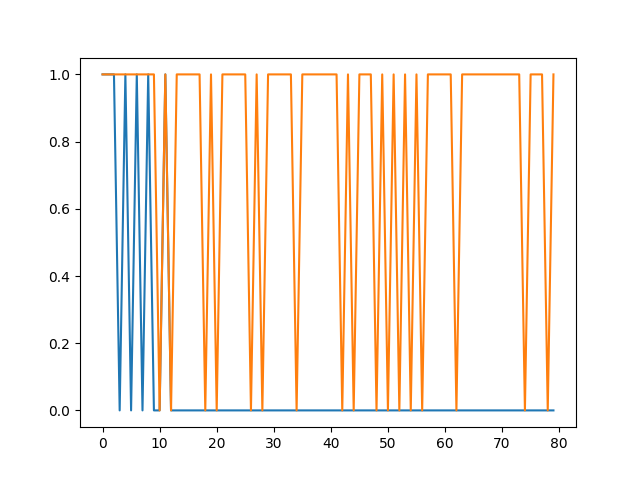

In [11]:
plt.figure()
plt.plot(mistakes_sin)
plt.plot(mistakes_slr)

Both models don't make mistakes anymore after a few epochs.

The same can be done with the moving checkerboard data instead of a rotating wheel (see `simple_task.py`). Here, the gradients for slayer need different scaling. It seems like bptt in sinabs is more robust here.